In [83]:
### IMPORT LIBRARIES
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.offline as py
import os, re, gc
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import plotly.graph_objs as go
import plotly.tools as tls
import matplotlib.pyplot as plt
import warnings
%matplotlib inline


In [84]:
### read train data
df = pd.read_csv('train.csv')
print(df.head(), '\n')
print(df.shape, '\n')
print(df.info())

   id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0   

(404290, 6) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-

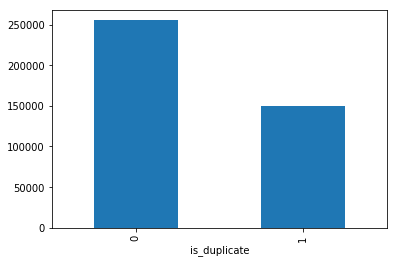

In [85]:
df.groupby('is_duplicate')['id'].count().plot(kind = 'bar')

In [86]:
df['is_duplicate'].value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

In [87]:
print('similar questions ratio  {}% '.format(149263/404290 * 100))

similar questions ratio  36.9197853026293% 


In [88]:
## lets look at distcint questions 
qid = pd.Series(df['qid1'].tolist()+ df['qid2'].tolist())
distinct_qs = len(np.unique(qid))
ques_more_than_once = np.sum(qid.value_counts()>1)
print(distinct_qs)
print(ques_more_than_once)
print('num of times a single question appears repeatedly {}'.format(max(qid.value_counts())))

537933
111780
num of times a single question appears repeatedly 157


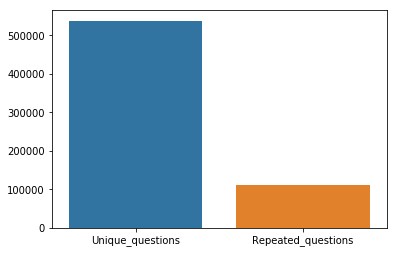

In [89]:
x = ['Unique_questions','Repeated_questions']
y = [distinct_qs, ques_more_than_once]
sns.barplot(x,y)
plt.show()

In [90]:
### check for duplicate entries
duplicate_pairs = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
duplicate_pairs.shape

(404290, 3)

In [9]:
### as we see there are no duplicate questions 
print(duplicate_pairs.shape[0]- df.shape[0])

0


Text(0.5, 0, 'frequecy of questions')

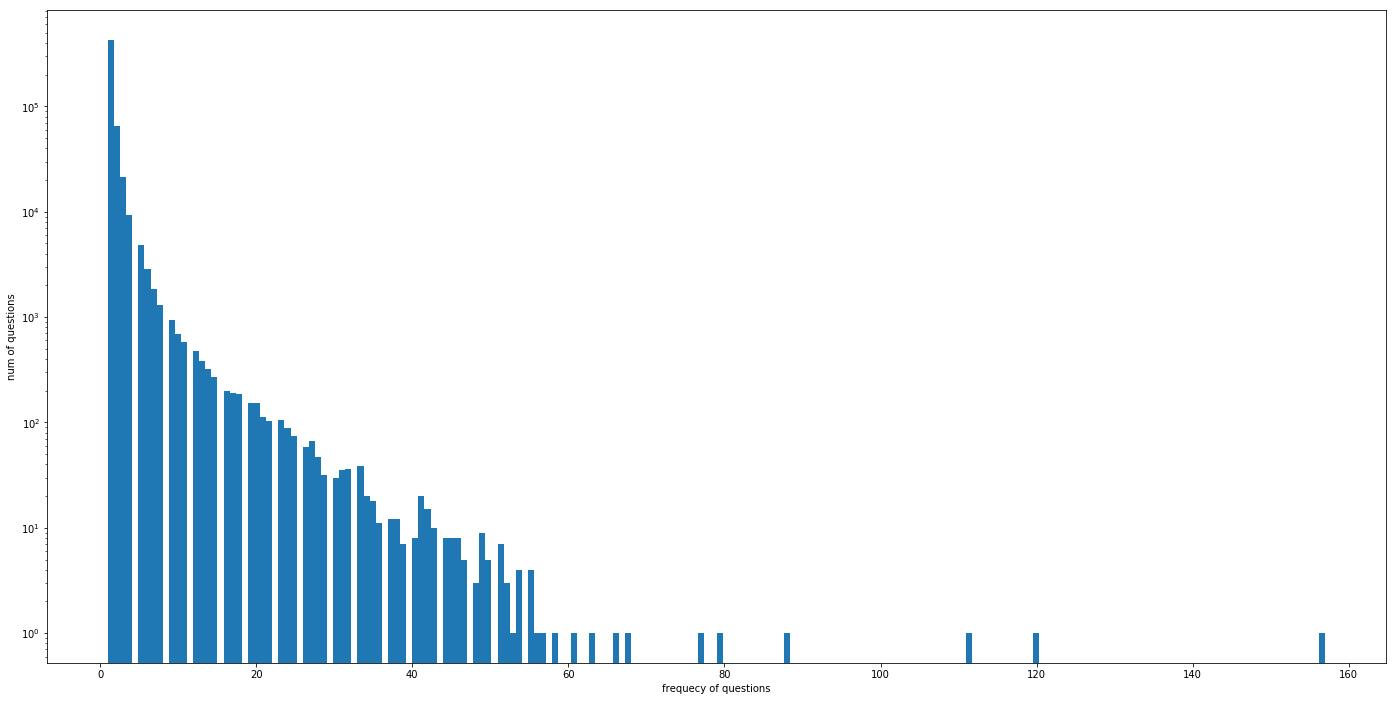

In [91]:
### frequecny of each question
plt.figure(figsize = (24,12))
plt.hist(qid.value_counts(), bins =200 )
plt.yscale('log')
plt.ylabel('num of questions')
plt.xlabel('frequecy of questions')

In [92]:
### check for null values
null_rows = df[df.isnull().any(1)]
print(null_rows)



            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


In [93]:
df = df.fillna('')
null_rows = df[df.isnull().any(1)]
print(len(null_rows))

0


In [94]:
## feature construction using qids and words in questions 1 & 2
df['qid1_freq'] = df.groupby('qid1')['qid1'].transform('count')
df['qid2_freq'] = df.groupby('qid2')['qid2'].transform('count')
df['q1+q2_freq'] = df['qid1_freq']+ df['qid2_freq']
df['q1-q2_freq'] = abs(df['qid1_freq']- df['qid2_freq'])
df['Q1_words'] = df['question1'].apply(lambda rows : len(rows.split(' ')))
df['Q2_words'] = df['question2'].apply(lambda rows : len(rows.split(' ')))
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  qid1_freq  \
0  What is the step by step guide to invest in sh...             0          1   
1  What would happen if the Indian government sto...             0          4   
2  How can Internet speed be increased by hacking...             0          1   
3  Find the remainder when [math]23^{24}[/math] i...             0          1   
4            Which fish would survive in salt water?             0          3   

   qid2_freq  q1+q2_freq  q1-q2_freq  Q1_words  Q2_words  
0          1           2           0        14        12  
1          1           5           3         8        13  
2          1           2           0        14        10  
3          1           2           0        11         9  
4          1           4           2        13         7

In [95]:
###common words in both questions
def common_words(row):
    w1 = set(map(lambda word : word.lower().strip(), row['question1'].split(' ')))
    w2 = set(map(lambda word : word.lower().strip(), row['question2'].split(' ')))
    return len(w1& w2)
df['words_common'] = df.apply(common_words , axis = 1)
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  qid1_freq  \
0  What is the step by step guide to invest in sh...             0          1   
1  What would happen if the Indian government sto...             0          4   
2  How can Internet speed be increased by hacking...             0          1   
3  Find the remainder when [math]23^{24}[/math] i...             0          1   
4            Which fish would survive in salt water?             0          3   

   qid2_freq  q1+q2_freq  q1-q2_freq  Q1_words  Q2_words  words_common  
0          1           2           0        14        12            10  
1          1           5           3         8        13             4  
2          1           2           0        14        10             4  
3          1           2           0        11         9             0  
4          1           4           2        13         7             2

In [15]:
### words shared by questions
def word_share(row):
    w1 = set(map(lambda word : word.lower().strip(), row['question1'].split(' ')))
    w2 = set(map(lambda word : word.lower().strip(), row['question2'].split(' ')))
    return len(w1& w2)/(len(w1)+ len(w2))
df['word_share'] = df.apply(word_share , axis = 1)
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  qid1_freq  \
0  What is the step by step guide to invest in sh...             0          1   
1  What would happen if the Indian government sto...             0          4   
2  How can Internet speed be increased by hacking...             0          1   
3  Find the remainder when [math]23^{24}[/math] i...             0          1   
4            Which fish would survive in salt water?             0          3   

   qid2_freq  q1+q2_freq  q1-q2_freq  Q1_words  Q2_words  words_common  \
0          1           2           0        14        12            10   
1          1           5           3         8        13             4   
2          1           2           0        14        10             4   
3          1           2           0        11         9             0   
4          1           4           2        13         7             2   

   word_share  
0    0.434783  
1    0.200000  
2    0.166667  
3    0.000000  
4    0.100000

In [16]:
### features extracted analysis and visualize 
print('question1 min length' , min(df['Q1_words']))
print('question2 min length' , min(df['Q2_words']))
print('num of min len questions in Q1 are :', len(df[df['Q1_words']==1]))

print('num of min len questions in Q2 are :', len(df[df['Q2_words']==1]))


question1 min length 1
question2 min length 1
num of min len questions in Q1 are : 67
num of min len questions in Q2 are : 24


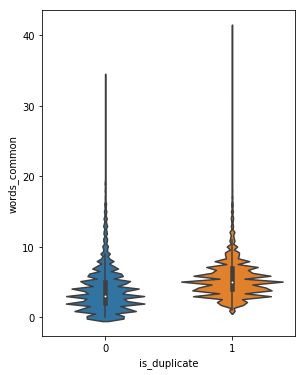

In [17]:
### word_common and word_share analysis
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate' , y = 'words_common' , data = df[0:])

plt.show()

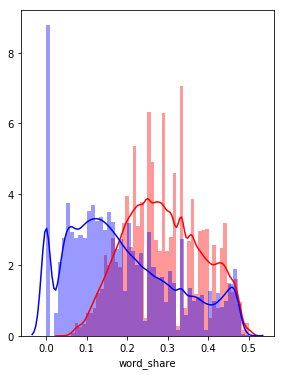

In [18]:
plt.figure(figsize=(10,6))

plt.subplot(1,2,1)

sns.distplot(df[df['is_duplicate']==1]['word_share'][0:], color = 'red')
sns.distplot(df[df['is_duplicate']==0]['word_share'][0:], color = 'blue')


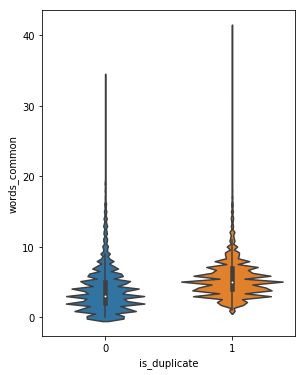

In [19]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate' , y = 'words_common' , data = df[0:])

plt.show()

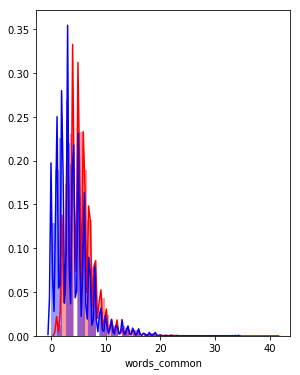

In [20]:
plt.figure(figsize=(10,6))

plt.subplot(1,2,1)

sns.distplot(df[df['is_duplicate']==1]['words_common'][0:], color = 'red')
sns.distplot(df[df['is_duplicate']==0]['words_common'][0:], color = 'blue')


### from above fig is can be seen that
from ditribution plot there is a overlap on right side , which shows so mnay words are common

# from violin plot(box plot analysis) it is seen that the duolicate qids have common words in both questions

In [96]:
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  qid1_freq  \
0  What is the step by step guide to invest in sh...             0          1   
1  What would happen if the Indian government sto...             0          4   
2  How can Internet speed be increased by hacking...             0          1   
3  Find the remainder when [math]23^{24}[/math] i...             0          1   
4            Which fish would survive in salt water?             0          3   

   qid2_freq  q1+q2_freq  q1-q2_freq  Q1_words  Q2_words  words_common  
0          1           2           0        14        12            10  
1          1           5           3         8        13             4  
2          1           2           0        14        10             4  
3          1           2           0        11         9             0  
4          1           4           2        13         7             2

In [97]:
df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

In [53]:
### text preprocesing 
### remove html tags, punctuations, stemming , stop words 
STOP_WORDS = stopwords.words('english')
porter = PorterStemmer()
def preprocess(x):
    x= str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub('<[^>]*>', '', x) ##remove html tags
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', x) ### remove emoticons 
    x = (re.sub('[\W]+', ' ', x.lower()) + ' '+' '.join(emoticons).replace('_', ''))
    if type(x)==type(''):
        x = porter.stem(x)
    
    return x



# Features:
cwc_min : Ratio of common_word_count to min lenghth of word count of Q1 and Q2 

cwc_max : Ratio of common_word_count to max lenghth of word count of Q1 and Q2 

csc_min : Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 

csc_max : Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2

ctc_min : Ratio of common_token_count to min lenghth of token count of Q1 and Q2

ctc_max : Ratio of common_token_count to max lenghth of token count of Q1 and Q2

last_word_eq : Check if First word of both questions is equal or not

first_word_eq : Check if First word of both questions is equal or not

abs_len_diff : Abs. length difference

mean_len : Average Token Length of both Questions

fuzz_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ 

fuzz_partial_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ 

token_sort_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ 

token_set_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ 

longest_substr_ratio : Ratio of length longest common substring to min lenghth of token count of Q1 and Q2
                                                        
                                                        

In [54]:
SAFE_DIV = 0.0001 

def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [55]:
### get the extracted features dataframe

df = extract_features(df)
df.head()


token features...
fuzzy features..


id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   
1   1     3     4  what is the story of kohinoor koh i noor diamo...   
2   2     5     6  how can i increase the speed of my internet co...   
3   3     7     8  why am i mentally very lonely how can i solve ...   
4   4     9    10  which one dissolve in water quikly sugar salt ...   

                                           question2  is_duplicate  qid1_freq  \
0  what is the step by step guide to invest in sh...             0          1   
1  what would happen if the indian government sto...             0          4   
2  how can internet speed be increased by hacking...             0          1   
3  find the remainder when math 23 24 math is div...             0          1   
4           which fish would survive in salt water               0          3   

   qid2_freq  q1+q2_freq  q1-q2_freq  ...   ctc_max  last_word_eq  \
0          1           2           0  ...  0.785709           0.0   
1          1           5           3  ...  0.466664           0.0   
2          1           2           0  ...  0.285712           0.0   
3          1           2           0  ...  0.000000           0.0   
4          1           4           2  ...  0.307690           0.0   

   first_word_eq  abs_len_diff  mean_len  token_set_ratio  token_sort_ratio  \
0            1.0           2.0      13.0              100                93   
1            1.0           5.0      12.5               86                63   
2            1.0           4.0      12.0               63                63   
3            0.0           2.0      12.0               28                24   
4            1.0           6.0      10.0               67                47   

   fuzz_ratio  fuzz_partial_ratio  longest_substr_ratio  
0          93                  98              0.966102  
1          65                  74              0.568627  
2          43                  48              0.163934  
3           9                  16              0.039216  
4          36                  57              0.170732  

[5 rows x 29 columns]

In [81]:
df.to_csv("nlp_features_train.csv", index=False)

In [57]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()


In [63]:
##Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

In [64]:
textp_w = open('train_p.txt').read()
textn_w = open('train_n.txt').read()

In [65]:
### analyse newly engineered features
## remove stopwords

stopwords = set(STOP_WORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")
stopwords.remove("no")

print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))


Total number of words in duplicate pair questions : 16319983
Total number of words in non duplicate pair questions : 33331116


Word Cloud for non-Duplicate Question pairs:


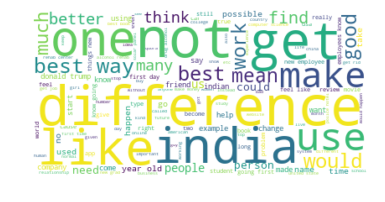

In [67]:
from wordcloud import WordCloud, STOPWORDS

### Word Clouds generated from non duplicate pair question's text
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for Duplicate Question pairs


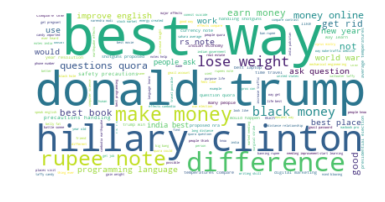

In [68]:
### Word Clouds generated from duplicate pair question's text
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [69]:
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm
import spacy

In [74]:
df1 = pd.read_csv("train.csv")
 
df1['question1'] = df1['question1'].apply(lambda x: str(x))
df1['question2'] = df1['question2'].apply(lambda x: str(x))

In [75]:
df1.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [76]:
# merge texts
questions = list(df1['question1']) + list(df1['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [77]:
# en_vectors_web_lg, which includes over 1 million unique vectors.

### the following 2 blocks of code to compute word vectors are going to take close to 2 hrs to run.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df1['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df1['q1_feats_m'] = list(vecs1)


  0%|          | 1287/404290 [00:15<1:17:45, 86.38it/s]


  1%|          | 2681/404290 [00:30<1:12:20, 92.53it/s]


  1%|          | 4119/404290 [00:45<1:14:12, 89.88it/s]


  1%|▏         | 5563/404290 [01:00<1:12:21, 91.83it/s]


  2%|▏         | 7018/404290 [01:16<1:10:28, 93.96it/s]


  2%|▏         | 8472/404290 [01:32<1:10:36, 93.42it/s]


  2%|▏         | 9904/404290 [01:47<1:06:57, 98.17it/s]


  3%|▎         | 11323/404290 [02:02<1:09:00, 94.90it/s]


  3%|▎         | 12715/404290 [02:16<1:04:14, 101.59it/s]


  3%|▎         | 14136/404290 [02:31<1:05:48, 98.81it/s] 


  4%|▍         | 15525/404290 [02:46<1:06:14, 97.82it/s]


  4%|▍         | 17009/404290 [03:01<56:09, 114.95it/s]


  5%|▍         | 18501/404290 [03:16<1:15:57, 84.65it/s]


  5%|▍         | 20034/404290 [03:31<55:32, 115.32it/s]


  5%|▌         | 21447/404290 [03:47<1:05:23, 97.59it/s]


  6%|▌         | 23014/404290 [04:02<58:49, 108.04it/s]


  6%|▌         | 24354/404290 [04:17<1:08:42, 92.16it/s]


  6%|▋         | 25797/404290 [04:32<1:05:30, 96.29it/s] 


  7%|▋         | 27256/404290 [04:47<1:01:56, 101.44it/s]


  7%|▋         | 28516/404290 [05:02<1:21:53, 76.48it/s]


  7%|▋         | 29942/404290 [05:16<1:02:54, 99.18it/s] 


  8%|▊         | 31209/404290 [05:32<1:41:14, 61.42it/s]


  8%|▊         | 32240/404290 [05:48<1:02:47, 98.75it/s]


  8%|▊         | 33613/404290 [06:02<1:07:44, 91.21it/s]


  9%|▊         | 34973/404290 [06:17<58:53, 104.53it/s]


  9%|▉         | 36459/404290 [06:32<59:07, 103.69it/s]  


  9%|▉         | 37923/404290 [06:47<1:02:40, 97.44it/s]


 10%|▉         | 39393/404290 [07:01<59:27, 102.27it/s]


 10%|█         | 40881/404290 [07:16<59:03, 102.57it/s] 


 10%|█         | 42362/404290 [07:31<1:00:29, 99.71it/s]


 11%|█         | 43877/404290 [07:46<1:01:16, 98.04it/s]


 11%|█         | 45315/404290 [08:02<1:15:26, 79.30it/s]


 12%|█▏        | 46799/404290 [08:16<56:00, 106.39it/s]


 12%|█▏        | 48335/404290 [08:31<56:01, 105.88it/s]


 12%|█▏        | 49200/404290 [47:48<2:33:30, 38.55it/s]


 12%|█▏        | 50143/404290 [48:05<1:07:37, 87.28it/s]


 13%|█▎        | 51688/404290 [48:21<53:38, 109.55it/s]


 13%|█▎        | 53243/404290 [48:36<1:01:56, 94.46it/s]


 14%|█▎        | 54592/404290 [48:52<2:01:16, 48.06it/s]


 14%|█▍        | 56166/404290 [49:07<53:55, 107.60it/s]


 14%|█▍        | 57786/404290 [49:22<1:01:47, 93.45it/s]


 15%|█▍        | 59041/404290 [49:39<1:33:40, 61.43it/s]


 15%|█▍        | 60459/404290 [49:56<50:55, 112.53it/s]


 15%|█▌        | 61795/404290 [50:13<1:17:16, 73.87it/s]


 16%|█▌        | 63427/404290 [50:28<49:47, 114.08it/s]


 16%|█▌        | 65033/404290 [50:44<58:37, 96.44it/s]


 16%|█▋        | 66469/404290 [50:59<58:16, 96.61it/s]  


 17%|█▋        | 67796/404290 [51:16<1:54:42, 48.89it/s]


 17%|█▋        | 69015/404290 [51:33<1:14:45, 74.75it/s]


 17%|█▋        | 70468/404290 [51:49<1:06:23, 83.80it/s]


 18%|█▊        | 71907/404290 [52:05<47:40, 116.21it/s]


 18%|█▊        | 73277/404290 [52:21<1:03:43, 86.58it/s]


 18%|█▊        | 74610/404290 [52:39<4:19:39, 21.16it/s]


 19%|█▉        | 75907/404290 [52:55<1:10:02, 78.15it/s]


 19%|█▉        | 77340/404290 [53:11<58:03, 93.86it/s]


 19%|█▉        | 78653/404290 [53:28<54:34, 99.44it/s] 


 20%|█▉        | 80014/404290 [53:45<1:18:05, 69.20it/s]


 20%|██        | 81211/404290 [54:02<54:07, 99.47it/s] 


 20%|██        | 82622/404290 [54:18<48:15, 111.09it/s]


 21%|██        | 84033/404290 [54:35<1:28:35, 60.25it/s]


 21%|██        | 85577/404290 [54:50<46:56, 113.16it/s]


 22%|██▏       | 87233/404290 [55:05<46:00, 114.86it/s]


 22%|██▏       | 88935/404290 [55:20<43:17, 121.40it/s]


 22%|██▏       | 90648/404290 [55:34<44:21, 117.86it/s]


 23%|██▎       | 92371/404290 [55:49<43:14, 120.20it/s]


 23%|██▎       | 94093/404290 [56:04<42:43, 120.99it/s]


 24%|██▎       | 95789/404290 [56:18<45:11, 113.77it/s]


 24%|██▍       | 97499/404290 [56:33<43:15, 118.19it/s]


 25%|██▍       | 99210/404290 [56:48<43:33, 116.73it/s]


 25%|██▍       | 100780/404290 [57:04<2:06:01, 40.14it/s]


 25%|██▌       | 102290/404290 [57:19<42:02, 119.72it/s]


 26%|██▌       | 103798/404290 [1:00:03<53:29, 93.62it/s]


 26%|██▌       | 105213/404290 [1:00:18<44:56, 110.89it/s]


 26%|██▋       | 106813/404290 [1:00:32<44:28, 111.46it/s]


 27%|██▋       | 108434/404290 [1:00:46<42:35, 115.76it/s]


 27%|██▋       | 109847/404290 [1:01:01<1:15:27, 65.03it/s]


 27%|██▋       | 111176/404290 [1:01:16<46:36, 104.83it/s]


 28%|██▊       | 112545/404290 [1:01:32<48:21, 100.54it/s]


 28%|██▊       | 114087/404290 [1:01:46<40:56, 118.14it/s]


 29%|██▊       | 115699/404290 [1:02:00<42:36, 112.87it/s]


 29%|██▉       | 117330/404290 [1:02:14<41:07, 116.32it/s]


 29%|██▉       | 118950/404290 [1:02:28<41:02, 115.86it/s]


 30%|██▉       | 120555/404290 [1:02:42<40:37, 116.41it/s]


 30%|███       | 122099/404290 [1:02:57<1:09:48, 67.38it/s]


 31%|███       | 123622/404290 [1:03:12<42:22, 110.38it/s]


 31%|███       | 125151/404290 [1:03:26<43:53, 106.00it/s]


 31%|███▏      | 126586/404290 [1:03:41<44:38, 103.68it/s]


 32%|███▏      | 128196/404290 [1:03:55<38:59, 118.03it/s]


 32%|███▏      | 129776/404290 [1:04:09<41:51, 109.30it/s]


 32%|███▏      | 131242/404290 [1:04:24<49:16, 92.37it/s]


 33%|███▎      | 132750/404290 [1:04:39<55:32, 81.49it/s]


 33%|███▎      | 134373/404290 [1:04:53<38:46, 116.00it/s]


 34%|███▎      | 135991/404290 [1:05:08<37:23, 119.59it/s]


 34%|███▍      | 137601/404290 [1:05:22<42:38, 104.24it/s]


 34%|███▍      | 139215/404290 [1:05:36<37:57, 116.39it/s]


 35%|███▍      | 140841/404290 [1:05:50<39:02, 112.46it/s]


 35%|███▌      | 142479/404290 [1:06:04<36:36, 119.20it/s]


 36%|███▌      | 143869/404290 [1:06:19<47:28, 91.43it/s]


 36%|███▌      | 145182/404290 [1:06:34<1:13:04, 59.09it/s]


 36%|███▌      | 146434/404290 [1:06:49<1:04:17, 66.84it/s]


 37%|███▋      | 147686/404290 [1:07:05<39:22, 108.63it/s]


 37%|███▋      | 149190/404290 [1:07:19<37:47, 112.52it/s]


 37%|███▋      | 150692/404290 [1:07:33<38:24, 110.07it/s]


 38%|███▊      | 152262/404290 [1:07:48<39:14, 107.06it/s]


 38%|███▊      | 153769/404290 [1:08:02<39:15, 106.37it/s]


 38%|███▊      | 155319/404290 [1:08:16<36:54, 112.41it/s]


 39%|███▉      | 156845/404290 [1:08:30<36:51, 111.89it/s]


 39%|███▉      | 158327/404290 [1:08:44<43:48, 93.58it/s]


 39%|███▉      | 159626/404290 [1:08:59<1:00:19, 67.59it/s]


 40%|███▉      | 161027/404290 [1:09:14<37:43, 107.47it/s]


 40%|████      | 162355/404290 [1:09:30<47:41, 84.55it/s]


 40%|████      | 163602/404290 [1:09:46<1:03:59, 62.69it/s]


 41%|████      | 164958/404290 [1:10:02<38:57, 102.39it/s]


 41%|████      | 166455/404290 [1:10:17<36:53, 107.44it/s]


 41%|████▏     | 167723/404290 [1:10:33<45:19, 86.99it/s]


 42%|████▏     | 169161/404290 [1:10:48<40:05, 97.73it/s] 


 42%|████▏     | 170714/404290 [1:11:02<36:11, 107.54it/s]


 43%|████▎     | 172269/404290 [1:11:16<37:15, 103.79it/s]


 43%|████▎     | 173813/404290 [1:11:31<35:22, 108.59it/s]


 43%|████▎     | 175353/404290 [1:11:45<36:55, 103.32it/s]


 44%|████▍     | 176895/404290 [1:11:59<44:54, 84.40it/s]


 44%|████▍     | 178240/404290 [1:12:15<35:14, 106.90it/s]


 44%|████▍     | 179700/404290 [1:12:30<35:08, 106.52it/s]


 45%|████▍     | 181291/404290 [1:12:44<31:42, 117.23it/s]


 45%|████▌     | 182906/404290 [1:12:58<31:04, 118.72it/s]


 46%|████▌     | 184537/404290 [1:13:12<31:08, 117.62it/s]


 46%|████▌     | 186159/404290 [1:13:26<32:11, 112.94it/s]


 46%|████▋     | 187232/404290 [1:13:44<1:11:55, 50.30it/s]


 47%|████▋     | 188524/404290 [1:14:00<43:36, 82.45it/s]


 47%|████▋     | 189767/404290 [1:14:17<2:49:04, 21.15it/s]


 47%|████▋     | 190872/404290 [1:14:35<1:00:15, 59.03it/s]


 48%|████▊     | 192423/404290 [1:14:52<52:41, 67.02it/s]


 48%|████▊     | 193766/404290 [1:15:09<34:26, 101.89it/s]


 48%|████▊     | 195141/404290 [1:15:25<41:27, 84.10it/s]


 49%|████▊     | 196438/404290 [1:15:41<31:10, 111.09it/s]


 49%|████▉     | 197790/404290 [1:15:57<46:32, 73.94it/s]


 49%|████▉     | 199216/404290 [1:16:11<35:28, 96.37it/s]


 50%|████▉     | 200542/404290 [1:16:25<32:08, 105.64it/s]


 50%|████▉     | 202034/404290 [1:16:41<55:59, 60.20it/s]


 50%|█████     | 203327/404290 [1:16:56<32:08, 104.18it/s]


 51%|█████     | 204827/404290 [1:17:11<30:12, 110.02it/s]


 51%|█████     | 206348/404290 [1:17:25<35:54, 91.89it/s]


 51%|█████▏    | 207809/404290 [1:17:40<28:43, 113.99it/s]


 52%|█████▏    | 209435/404290 [1:17:54<29:24, 110.44it/s]


 52%|█████▏    | 210909/404290 [1:18:09<36:41, 87.83it/s]


 52%|█████▏    | 212085/404290 [1:18:27<42:01, 76.22it/s]


 53%|█████▎    | 213276/404290 [1:18:44<31:02, 102.54it/s]


 53%|█████▎    | 214752/404290 [1:18:59<34:36, 91.27it/s]


 53%|█████▎    | 216153/404290 [1:19:15<27:35, 113.64it/s]


 54%|█████▍    | 217620/404290 [1:19:31<35:33, 87.50it/s]


 54%|█████▍    | 219009/404290 [1:19:47<37:34, 82.17it/s]


 54%|█████▍    | 220238/404290 [1:20:05<1:20:03, 38.32it/s]


 55%|█████▍    | 221699/404290 [1:20:20<27:24, 111.06it/s]


 55%|█████▌    | 223084/404290 [1:20:36<33:24, 90.41it/s]


 56%|█████▌    | 224393/404290 [1:20:54<36:08, 82.96it/s]


 56%|█████▌    | 225761/404290 [1:21:10<27:01, 110.10it/s]


 56%|█████▌    | 226968/404290 [1:21:28<33:40, 87.75it/s]


 56%|█████▋    | 228360/404290 [1:21:43<41:35, 70.51it/s]


 57%|█████▋    | 229589/404290 [1:21:59<28:40, 101.57it/s]


 57%|█████▋    | 231122/404290 [1:22:14<27:13, 106.01it/s]


 58%|█████▊    | 232719/404290 [1:22:28<26:01, 109.90it/s]


 58%|█████▊    | 234314/404290 [1:22:42<24:34, 115.27it/s]


 58%|█████▊    | 235755/404290 [1:22:57<28:12, 99.56it/s] 


 59%|█████▊    | 237302/404290 [1:23:12<25:58, 107.16it/s]


 59%|█████▉    | 238667/404290 [1:23:27<31:26, 87.78it/s]


 59%|█████▉    | 239943/404290 [1:23:43<26:01, 105.23it/s]


 60%|█████▉    | 241396/404290 [1:23:57<28:24, 95.57it/s]


 60%|██████    | 242856/404290 [1:24:12<27:31, 97.77it/s] 


 60%|██████    | 244221/404290 [1:24:28<30:29, 87.49it/s]


 61%|██████    | 245646/404290 [1:24:42<24:57, 105.91it/s]


 61%|██████    | 246881/404290 [1:24:59<30:49, 85.10it/s]


 61%|██████▏   | 248041/404290 [1:25:18<46:28, 56.04it/s]


 62%|██████▏   | 249510/404290 [1:25:33<28:24, 90.81it/s]


 62%|██████▏   | 250902/404290 [1:25:49<31:13, 81.88it/s]


 62%|██████▏   | 252356/404290 [1:26:04<25:21, 99.85it/s] 


 63%|██████▎   | 253619/404290 [1:26:22<51:47, 48.49it/s]


 63%|██████▎   | 254867/404290 [1:26:38<32:46, 76.00it/s]


 63%|██████▎   | 255940/404290 [1:26:55<46:47, 52.83it/s]


 64%|██████▎   | 256821/404290 [1:27:11<41:09, 59.71it/s]


 64%|██████▎   | 257687/404290 [1:27:26<39:57, 61.15it/s]


 64%|██████▍   | 258632/404290 [1:27:42<34:25, 70.51it/s]


 64%|██████▍   | 259758/404290 [1:27:58<34:18, 70.22it/s]


 65%|██████▍   | 261084/404290 [1:28:13<21:12, 112.51it/s]


 65%|██████▍   | 262121/404290 [1:28:31<34:26, 68.81it/s]


 65%|██████▌   | 263389/404290 [1:28:47<22:48, 102.96it/s]


 66%|██████▌   | 264842/404290 [1:29:01<21:28, 108.21it/s]


 66%|██████▌   | 266340/404290 [1:29:16<22:45, 101.00it/s]


 66%|██████▌   | 267758/404290 [1:29:31<20:01, 113.59it/s]


 67%|██████▋   | 269161/404290 [1:29:47<25:55, 86.89it/s]


 67%|██████▋   | 270626/404290 [1:30:01<24:40, 90.26it/s]


 67%|██████▋   | 272099/404290 [1:30:15<20:10, 109.20it/s]


 68%|██████▊   | 273629/404290 [1:30:30<23:32, 92.47it/s] 


 68%|██████▊   | 275042/404290 [1:30:45<20:28, 105.22it/s]


 68%|██████▊   | 276540/404290 [1:31:00<19:14, 110.69it/s]


 69%|██████▉   | 278039/404290 [1:31:15<22:08, 95.01it/s]


 69%|██████▉   | 279245/404290 [1:31:31<22:22, 93.15it/s]


 69%|██████▉   | 280575/404290 [1:31:47<19:35, 105.28it/s]


 70%|██████▉   | 282008/404290 [1:32:02<18:09, 112.23it/s]


 70%|███████   | 283490/404290 [1:32:16<26:25, 76.17it/s]


 70%|███████   | 284999/404290 [1:32:31<18:29, 107.49it/s]


 71%|███████   | 286517/404290 [1:32:45<18:34, 105.64it/s]


 71%|███████   | 288046/404290 [1:32:59<17:41, 109.48it/s]


 72%|███████▏  | 289550/404290 [1:33:13<17:26, 109.67it/s]


 72%|███████▏  | 291057/404290 [1:33:28<19:59, 94.37it/s]


 72%|███████▏  | 292475/404290 [1:33:43<17:19, 107.58it/s]


 73%|███████▎  | 293437/404290 [1:33:59<32:01, 57.69it/s]


 73%|███████▎  | 294672/404290 [1:34:14<22:16, 82.04it/s]


 73%|███████▎  | 296107/404290 [1:34:30<21:29, 83.87it/s]


 74%|███████▎  | 297529/404290 [1:34:45<16:27, 108.15it/s]


 74%|███████▍  | 299102/404290 [1:34:59<15:52, 110.39it/s]


 74%|███████▍  | 300657/404290 [1:35:14<20:07, 85.81it/s]


 75%|███████▍  | 302134/404290 [1:35:28<16:48, 101.29it/s]


 75%|███████▌  | 303582/404290 [1:35:43<15:30, 108.21it/s]


 75%|███████▌  | 305013/404290 [1:35:58<18:29, 89.51it/s]


 76%|███████▌  | 306468/404290 [1:36:13<16:35, 98.25it/s]


 76%|███████▌  | 307901/404290 [1:36:27<14:58, 107.25it/s]


 77%|███████▋  | 309377/404290 [1:36:42<15:43, 100.63it/s]


 77%|███████▋  | 310914/404290 [1:36:57<15:45, 98.72it/s]


 77%|███████▋  | 312420/404290 [1:37:11<14:32, 105.30it/s]


 78%|███████▊  | 313344/404290 [1:37:27<31:42, 47.80it/s]


 78%|███████▊  | 314337/404290 [1:37:42<16:40, 89.92it/s] 


 78%|███████▊  | 315754/404290 [1:37:57<14:04, 104.83it/s]


 78%|███████▊  | 317154/404290 [1:38:12<15:19, 94.77it/s]


 79%|███████▉  | 318565/404290 [1:38:28<15:48, 90.41it/s] 


 79%|███████▉  | 319898/404290 [1:38:43<14:27, 97.32it/s]


 79%|███████▉  | 321321/404290 [1:38:58<14:22, 96.17it/s] 


 80%|███████▉  | 322812/404290 [1:39:13<18:42, 72.58it/s]


 80%|████████  | 324118/404290 [1:39:29<15:09, 88.19it/s]


 81%|████████  | 325620/404290 [1:39:44<11:56, 109.86it/s]


 81%|████████  | 327141/404290 [1:39:59<12:38, 101.77it/s]


 81%|████████▏ | 328647/404290 [1:40:14<13:11, 95.51it/s] 


 82%|████████▏ | 329998/404290 [1:40:29<14:58, 82.67it/s]


 82%|████████▏ | 331449/404290 [1:40:44<12:38, 96.00it/s]


 82%|████████▏ | 332910/404290 [1:40:59<18:41, 63.65it/s]


 83%|████████▎ | 334398/404290 [1:41:14<11:18, 103.05it/s]


 83%|████████▎ | 335731/404290 [1:41:29<13:08, 86.98it/s]


 83%|████████▎ | 337174/404290 [1:41:44<13:49, 80.86it/s]


 84%|████████▍ | 338641/404290 [1:41:59<10:31, 103.89it/s]


 84%|████████▍ | 340217/404290 [1:42:13<09:55, 107.57it/s]


 85%|████████▍ | 341755/404290 [1:42:28<10:54, 95.60it/s]


 85%|████████▍ | 342994/404290 [1:42:44<16:39, 61.30it/s]


 85%|████████▌ | 344053/404290 [1:43:01<19:29, 51.49it/s]


 85%|████████▌ | 345340/404290 [1:43:16<11:51, 82.84it/s]


 86%|████████▌ | 346811/404290 [1:43:30<09:45, 98.24it/s]


 86%|████████▌ | 348158/404290 [1:43:46<09:38, 96.97it/s]


 86%|████████▋ | 349538/404290 [1:44:01<11:23, 80.09it/s]


 87%|████████▋ | 350943/404290 [1:44:16<08:01, 110.85it/s]


 87%|████████▋ | 352495/404290 [1:44:30<07:34, 113.84it/s]


 88%|████████▊ | 354043/404290 [1:44:44<08:28, 98.74it/s]


 88%|████████▊ | 355439/404290 [1:44:59<10:44, 75.75it/s]


 88%|████████▊ | 356841/404290 [1:45:14<08:01, 98.45it/s]


 89%|████████▊ | 358187/404290 [1:45:29<08:02, 95.59it/s]


 89%|████████▉ | 359672/404290 [1:45:44<06:43, 110.63it/s]


 89%|████████▉ | 361025/404290 [1:45:59<08:05, 89.16it/s]


 90%|████████▉ | 362224/404290 [1:46:15<12:44, 54.99it/s]


 90%|████████▉ | 363013/404290 [1:46:32<09:32, 72.12it/s]


 90%|█████████ | 364339/404290 [1:46:46<06:42, 99.20it/s]


 90%|█████████ | 365754/404290 [1:47:01<06:41, 96.04it/s]


 91%|█████████ | 367173/404290 [1:47:17<08:27, 73.07it/s]


 91%|█████████ | 368442/404290 [1:47:32<05:28, 109.19it/s]


 91%|█████████▏| 369910/404290 [1:47:47<05:50, 98.02it/s] 


 92%|█████████▏| 371296/404290 [1:48:02<05:05, 107.86it/s]


 92%|█████████▏| 372675/404290 [1:48:18<04:53, 107.63it/s]


 93%|█████████▎| 374136/404290 [1:48:32<05:15, 95.51it/s]


 93%|█████████▎| 375506/404290 [1:48:47<04:34, 104.99it/s]


 93%|█████████▎| 376980/404290 [1:49:01<04:28, 101.88it/s]


 94%|█████████▎| 378447/404290 [1:49:16<04:12, 102.28it/s]


 94%|█████████▍| 379882/404290 [1:49:31<05:15, 77.28it/s]


 94%|█████████▍| 381262/404290 [1:49:46<06:56, 55.31it/s]


 95%|█████████▍| 382570/404290 [1:50:03<05:10, 69.94it/s]


 95%|█████████▍| 384002/404290 [1:50:19<04:36, 73.48it/s]


 95%|█████████▌| 385367/404290 [1:50:34<03:37, 86.85it/s]


 96%|█████████▌| 386624/404290 [1:50:50<03:22, 87.43it/s]


 96%|█████████▌| 387629/404290 [1:51:07<06:04, 45.66it/s]


 96%|█████████▌| 388549/404290 [1:51:23<03:34, 73.43it/s]


 96%|█████████▋| 389723/404290 [1:51:39<02:45, 88.17it/s]


 97%|█████████▋| 391131/404290 [1:51:54<02:01, 108.12it/s]


 97%|█████████▋| 392632/404290 [1:52:08<01:50, 105.44it/s]


 97%|█████████▋| 394104/404290 [1:52:23<01:39, 102.81it/s]


 98%|█████████▊| 395583/404290 [1:52:37<01:22, 106.06it/s]


 98%|█████████▊| 397086/404290 [1:52:51<01:16, 94.44it/s]


 99%|█████████▊| 398471/404290 [1:53:05<01:02, 93.36it/s]


 99%|█████████▉| 399349/404290 [1:53:23<02:01, 40.77it/s]


 99%|█████████▉| 400433/404290 [1:53:39<00:58, 66.00it/s]


 99%|█████████▉| 401590/404290 [1:53:55<01:11, 37.51it/s]


100%|█████████▉| 402737/404290 [1:54:11<00:25, 62.09it/s]


100%|█████████▉| 403792/404290 [1:54:27<00:06, 71.37it/s]


100%|██████████| 404290/404290 [1:54:34<00:00, 58.81it/s]

In [80]:
vecs2 = []
for qu2 in tqdm(list(df1['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df1['q2_feats_m'] = list(vecs2)


  0%|          | 1141/404290 [00:17<2:28:01, 45.39it/s]


  1%|          | 2517/404290 [00:33<2:03:49, 54.08it/s]


  1%|          | 3884/404290 [00:49<1:21:22, 82.01it/s]


  1%|▏         | 5263/404290 [01:06<56:07, 118.51it/s]


  2%|▏         | 6908/404290 [01:22<1:10:23, 94.10it/s]


  2%|▏         | 8436/404290 [01:38<1:13:00, 90.37it/s]


  2%|▏         | 9990/404290 [01:53<1:11:56, 91.35it/s]


  3%|▎         | 11440/404290 [02:09<1:33:22, 70.13it/s]


  3%|▎         | 12666/404290 [02:26<1:21:43, 79.87it/s]


  3%|▎         | 14109/404290 [02:41<1:01:16, 106.12it/s]


  4%|▍         | 15617/404290 [02:56<1:03:01, 102.78it/s]


  4%|▍         | 16987/404290 [03:13<1:29:25, 72.19it/s]


  5%|▍         | 18210/404290 [03:29<1:02:50, 102.39it/s]


  5%|▍         | 19665/404290 [03:45<1:21:53, 78.29it/s]


  5%|▌         | 20881/404290 [04:03<1:20:39, 79.22it/s]


  5%|▌         | 22141/404290 [04:19<1:01:39, 103.30it/s]


  6%|▌         | 23667/404290 [04:34<55:32, 114.23it/s]


  6%|▌         | 25224/404290 [04:49<1:08:57, 91.62it/s]


  7%|▋         | 26801/404290 [05:04<56:20, 111.65it/s]


  7%|▋         | 28363/404290 [05:18<57:11, 109.55it/s]


  7%|▋         | 29999/404290 [05:33<55:36, 112.17it/s]


  8%|▊         | 31613/404290 [05:48<59:00, 105.25it/s]


  8%|▊         | 33127/404290 [06:03<59:45, 103.52it/s]


  9%|▊         | 34592/404290 [06:19<1:03:27, 97.10it/s]


  9%|▉         | 35995/404290 [06:34<57:50, 106.13it/s]


  9%|▉         | 37512/404290 [06:49<53:24, 114.45it/s]


 10%|▉         | 38960/404290 [07:04<1:03:37, 95.71it/s]


 10%|▉         | 40333/404290 [07:20<1:33:50, 64.64it/s]


 10%|█         | 41542/404290 [07:37<2:24:07, 41.95it/s]


 11%|█         | 42581/404290 [07:54<1:26:06, 70.01it/s]


 11%|█         | 44117/404290 [08:09<1:15:57, 79.04it/s]


 11%|█         | 45404/404290 [08:26<1:12:10, 82.88it/s]


 12%|█▏        | 46510/404290 [08:42<1:16:05, 78.37it/s]


 12%|█▏        | 47792/404290 [08:58<1:11:19, 83.31it/s]


 12%|█▏        | 49145/404290 [09:14<1:34:22, 62.72it/s]


 12%|█▏        | 50387/404290 [09:30<1:06:44, 88.38it/s]


 13%|█▎        | 51802/404290 [09:46<1:01:42, 95.20it/s]


 13%|█▎        | 53446/404290 [10:01<49:02, 119.25it/s]


 14%|█▎        | 54751/404290 [10:17<1:07:12, 86.69it/s]


 14%|█▍        | 56049/404290 [10:33<1:04:45, 89.63it/s]


 14%|█▍        | 57477/404290 [10:49<51:43, 111.76it/s]


 15%|█▍        | 58702/404290 [11:06<1:44:49, 54.95it/s]


 15%|█▍        | 60116/404290 [11:22<1:12:13, 79.42it/s]


 15%|█▌        | 61445/404290 [11:39<1:08:55, 82.90it/s]


 16%|█▌        | 62862/404290 [11:55<1:22:36, 68.88it/s]


 16%|█▌        | 64289/404290 [12:10<1:02:44, 90.33it/s]


 16%|█▌        | 65494/404290 [12:27<1:14:48, 75.48it/s]


 17%|█▋        | 66729/404290 [12:43<58:16, 96.55it/s]  


 17%|█▋        | 68403/404290 [12:58<47:49, 117.06it/s]


 17%|█▋        | 70079/404290 [13:13<50:08, 111.10it/s]


 18%|█▊        | 71760/404290 [13:28<51:15, 108.13it/s]


 18%|█▊        | 73363/404290 [13:43<55:02, 100.22it/s]


 19%|█▊        | 74926/404290 [13:59<59:57, 91.54it/s]


 19%|█▉        | 75890/404290 [14:17<1:19:02, 69.25it/s]


 19%|█▉        | 77120/404290 [14:33<1:10:30, 77.34it/s]


 19%|█▉        | 78405/404290 [14:49<1:13:08, 74.25it/s]


 20%|█▉        | 79758/404290 [15:05<1:12:56, 74.15it/s]


 20%|██        | 81313/404290 [15:20<59:49, 89.98it/s]


 20%|██        | 82841/404290 [15:35<54:20, 98.60it/s]


 21%|██        | 84059/404290 [15:52<1:18:59, 67.57it/s]


 21%|██        | 85325/404290 [16:09<1:25:10, 62.42it/s]


 21%|██▏       | 86749/404290 [16:24<57:32, 91.96it/s]  


 22%|██▏       | 87964/404290 [16:42<1:12:26, 72.78it/s]


 22%|██▏       | 89281/404290 [16:58<57:06, 91.93it/s]


 22%|██▏       | 90820/404290 [17:14<48:29, 107.75it/s]


 23%|██▎       | 92400/404290 [17:30<47:02, 110.49it/s]


 23%|██▎       | 94039/404290 [17:45<45:25, 113.85it/s]


 24%|██▎       | 95399/404290 [18:02<1:12:20, 71.17it/s]


 24%|██▍       | 96690/404290 [18:18<1:08:52, 74.44it/s]


 24%|██▍       | 97940/404290 [18:35<1:17:36, 65.79it/s]


 25%|██▍       | 99488/404290 [18:50<56:15, 90.30it/s]


 25%|██▌       | 101075/404290 [19:06<56:32, 89.39it/s]


 25%|██▌       | 102318/404290 [19:22<1:19:43, 63.13it/s]


 26%|██▌       | 103498/404290 [19:39<1:36:49, 51.77it/s]


 26%|██▌       | 104703/404290 [19:55<1:10:57, 70.36it/s]


 26%|██▌       | 105706/404290 [20:15<2:01:16, 41.03it/s]


 26%|██▋       | 106896/404290 [20:31<1:17:14, 64.17it/s]


 27%|██▋       | 108165/404290 [20:48<46:52, 105.29it/s]


 27%|██▋       | 109683/404290 [21:03<1:00:43, 80.86it/s]


 27%|██▋       | 111077/404290 [21:19<45:31, 107.34it/s]


 28%|██▊       | 112331/404290 [21:34<48:57, 99.39it/s]


 28%|██▊       | 113788/404290 [21:49<49:49, 97.17it/s]


 28%|██▊       | 115218/404290 [22:04<49:43, 96.89it/s]


 29%|██▉       | 116669/404290 [22:19<49:56, 95.99it/s]


 29%|██▉       | 118049/404290 [22:34<51:33, 92.53it/s]


 30%|██▉       | 119505/404290 [22:49<54:53, 86.47it/s]


 30%|██▉       | 120943/404290 [23:04<47:08, 100.18it/s]


 30%|███       | 122402/404290 [23:19<49:04, 95.72it/s]


 31%|███       | 123741/404290 [23:35<3:22:45, 23.06it/s]


 31%|███       | 124504/404290 [23:56<1:59:50, 38.91it/s]


 31%|███       | 125763/404290 [24:13<1:03:27, 73.14it/s]


 31%|███▏      | 127126/404290 [24:28<50:05, 92.22it/s]


 32%|███▏      | 128522/404290 [24:44<50:49, 90.44it/s]


 32%|███▏      | 130008/404290 [24:59<43:28, 105.15it/s]


 32%|███▏      | 131337/404290 [25:15<52:27, 86.71it/s]


 33%|███▎      | 132716/404290 [25:30<45:33, 99.35it/s]


 33%|███▎      | 134140/404290 [25:46<44:36, 100.95it/s]


 34%|███▎      | 135618/404290 [26:01<46:05, 97.15it/s]


 34%|███▍      | 137107/404290 [26:17<42:18, 105.25it/s]


 34%|███▍      | 138698/404290 [26:32<42:39, 103.76it/s]


 35%|███▍      | 140347/404290 [26:47<39:03, 112.63it/s]


 35%|███▌      | 141975/404290 [27:01<39:23, 110.97it/s]


 36%|███▌      | 143634/404290 [27:16<37:48, 114.89it/s]


 36%|███▌      | 145291/404290 [27:31<43:38, 98.92it/s]


 36%|███▋      | 146960/404290 [27:45<35:52, 119.56it/s]


 37%|███▋      | 148630/404290 [28:00<36:31, 116.65it/s]


 37%|███▋      | 150240/404290 [28:15<35:29, 119.29it/s]


 38%|███▊      | 151869/404290 [28:29<35:40, 117.95it/s]


 38%|███▊      | 153532/404290 [28:44<37:23, 111.75it/s]


 38%|███▊      | 155070/404290 [28:59<38:09, 108.86it/s]


 39%|███▊      | 156590/404290 [29:14<43:53, 94.05it/s]


 39%|███▉      | 158184/404290 [29:29<35:24, 115.86it/s]


 40%|███▉      | 159808/404290 [29:44<35:07, 116.03it/s]


 40%|███▉      | 161470/404290 [29:58<35:18, 114.62it/s]


 40%|████      | 163090/404290 [30:13<40:04, 100.33it/s]


 41%|████      | 164735/404290 [30:27<34:37, 115.32it/s]


 41%|████      | 166383/404290 [30:42<34:24, 115.25it/s]


 42%|████▏     | 168047/404290 [30:57<34:53, 112.83it/s]


 42%|████▏     | 169719/404290 [31:11<34:50, 112.21it/s]


 42%|████▏     | 171383/404290 [31:26<33:35, 115.57it/s]


 43%|████▎     | 172949/404290 [31:41<33:08, 116.34it/s]


 43%|████▎     | 174593/404290 [31:56<33:26, 114.50it/s]


 43%|████▎     | 175779/404290 [32:12<1:07:18, 56.59it/s]


 44%|████▎     | 176768/404290 [32:28<1:04:28, 58.81it/s]


 44%|████▍     | 178151/404290 [32:44<44:33, 84.60it/s]


 44%|████▍     | 179636/404290 [32:59<1:32:09, 40.63it/s]


 45%|████▍     | 180908/404290 [33:16<37:38, 98.91it/s]


 45%|████▌     | 182299/404290 [33:31<38:18, 96.57it/s]


 45%|████▌     | 183739/404290 [33:47<36:54, 99.59it/s] 


 46%|████▌     | 185239/404290 [34:03<40:15, 90.69it/s]


 46%|████▌     | 186626/404290 [34:20<46:53, 77.37it/s]


 46%|████▋     | 187681/404290 [34:37<47:57, 75.27it/s]


 47%|████▋     | 189111/404290 [34:53<33:07, 108.26it/s]


 47%|████▋     | 190547/404290 [35:09<38:59, 91.38it/s]


 47%|████▋     | 191828/404290 [35:25<43:54, 80.65it/s]


 48%|████▊     | 193200/404290 [35:41<36:33, 96.25it/s]


 48%|████▊     | 194608/404290 [35:57<30:25, 114.89it/s]


 48%|████▊     | 195822/404290 [36:14<55:22, 62.74it/s]


 49%|████▊     | 197057/404290 [36:31<58:45, 58.77it/s]  


 49%|████▉     | 198460/404290 [36:47<32:52, 104.32it/s]


 49%|████▉     | 199937/404290 [37:02<33:18, 102.28it/s]


 50%|████▉     | 201396/404290 [37:18<43:55, 76.98it/s]


 50%|█████     | 202761/404290 [37:34<32:41, 102.74it/s]


 51%|█████     | 204229/404290 [37:50<30:41, 108.62it/s]


 51%|█████     | 205709/404290 [38:05<30:44, 107.66it/s]


 51%|█████     | 206952/404290 [38:23<2:03:57, 26.53it/s]


 51%|█████▏    | 208148/404290 [38:40<40:41, 80.35it/s]


 52%|█████▏    | 209526/404290 [38:55<37:53, 85.68it/s]


 52%|█████▏    | 210847/404290 [39:11<42:24, 76.02it/s]


 52%|█████▏    | 212148/404290 [39:27<39:19, 81.45it/s]


 53%|█████▎    | 213546/404290 [39:42<37:43, 84.26it/s]


 53%|█████▎    | 214737/404290 [39:59<44:33, 70.90it/s]


 53%|█████▎    | 215983/404290 [40:17<45:51, 68.43it/s]


 54%|█████▎    | 217281/404290 [40:35<43:06, 72.30it/s]


 54%|█████▍    | 218657/404290 [40:51<32:42, 94.61it/s]


 54%|█████▍    | 219970/404290 [41:09<1:00:53, 50.44it/s]


 55%|█████▍    | 221218/404290 [41:25<39:11, 77.84it/s]


 55%|█████▌    | 222528/404290 [41:41<29:09, 103.91it/s]


 55%|█████▌    | 224062/404290 [41:56<27:38, 108.66it/s]


 56%|█████▌    | 225587/404290 [42:11<29:29, 100.96it/s]


 56%|█████▌    | 227085/404290 [42:26<27:23, 107.83it/s]


 57%|█████▋    | 228648/404290 [42:41<27:54, 104.92it/s]


 57%|█████▋    | 230221/404290 [42:56<28:27, 101.96it/s]


 57%|█████▋    | 231387/404290 [43:12<34:54, 82.54it/s]


 58%|█████▊    | 232808/404290 [43:28<27:36, 103.54it/s]


 58%|█████▊    | 234260/404290 [43:43<25:39, 110.47it/s]


 58%|█████▊    | 235537/404290 [44:00<34:38, 81.17it/s]


 59%|█████▊    | 236865/404290 [44:16<35:55, 77.66it/s]


 59%|█████▉    | 238203/404290 [44:32<24:55, 111.06it/s]


 59%|█████▉    | 239751/404290 [44:47<27:41, 99.01it/s]


 60%|█████▉    | 241368/404290 [45:01<23:33, 115.29it/s]


 60%|██████    | 243021/404290 [45:16<24:24, 110.10it/s]


 61%|██████    | 244660/404290 [45:31<22:48, 116.68it/s]


 61%|██████    | 246218/404290 [45:46<23:39, 111.39it/s]


 61%|██████▏   | 247798/404290 [46:01<24:26, 106.75it/s]


 62%|██████▏   | 249111/404290 [46:19<23:43, 108.98it/s]


 62%|██████▏   | 250634/404290 [46:35<36:37, 69.93it/s]


 62%|██████▏   | 251823/404290 [46:52<29:19, 86.66it/s]


 63%|██████▎   | 253268/404290 [47:08<25:26, 98.91it/s] 


 63%|██████▎   | 254813/404290 [47:23<25:19, 98.35it/s]


 63%|██████▎   | 256396/404290 [47:38<21:04, 116.94it/s]


 64%|██████▍   | 258030/404290 [47:53<22:04, 110.41it/s]


 64%|██████▍   | 259658/404290 [48:08<21:42, 111.03it/s]


 65%|██████▍   | 261193/404290 [48:23<21:25, 111.32it/s]


 65%|██████▌   | 262822/404290 [48:38<21:23, 110.21it/s]


 65%|██████▌   | 264466/404290 [48:52<21:19, 109.32it/s]


 66%|██████▌   | 266043/404290 [49:07<22:25, 102.76it/s]


 66%|██████▌   | 267617/404290 [49:22<20:09, 113.01it/s]


 67%|██████▋   | 269277/404290 [49:37<19:23, 116.01it/s]


 67%|██████▋   | 270924/404290 [49:51<19:43, 112.72it/s]


 67%|██████▋   | 272500/404290 [50:08<1:10:50, 31.01it/s]


 68%|██████▊   | 273591/404290 [50:25<29:26, 74.00it/s]


 68%|██████▊   | 274707/404290 [50:42<39:01, 55.33it/s]


 68%|██████▊   | 276030/404290 [50:58<35:43, 59.84it/s]


 69%|██████▊   | 277528/404290 [51:13<35:04, 60.25it/s]


 69%|██████▉   | 278999/404290 [51:29<22:25, 93.09it/s] 


 69%|██████▉   | 280275/404290 [51:46<20:41, 99.87it/s]


 70%|██████▉   | 281563/404290 [52:02<22:25, 91.22it/s]


 70%|██████▉   | 282843/404290 [52:19<29:40, 68.20it/s]


 70%|███████   | 284286/404290 [52:35<21:27, 93.23it/s] 


 71%|███████   | 285806/404290 [52:50<20:34, 95.99it/s]


 71%|███████   | 287318/404290 [53:06<18:06, 107.69it/s]


 71%|███████▏  | 288913/404290 [53:20<17:14, 111.57it/s]


 72%|███████▏  | 290503/404290 [53:35<16:38, 113.98it/s]


 72%|███████▏  | 292014/404290 [53:51<18:31, 100.99it/s]


 73%|███████▎  | 293578/404290 [54:06<17:18, 106.60it/s]


 73%|███████▎  | 295108/404290 [54:22<21:59, 82.72it/s]


 73%|███████▎  | 296682/404290 [54:37<15:30, 115.68it/s]


 74%|███████▍  | 298244/404290 [54:52<16:47, 105.21it/s]


 74%|███████▍  | 299796/404290 [55:07<19:48, 87.93it/s]


 75%|███████▍  | 301346/404290 [55:23<14:49, 115.67it/s]


 75%|███████▍  | 302924/404290 [55:38<15:37, 108.14it/s]


 75%|███████▌  | 304442/404290 [55:54<17:21, 95.88it/s] 


 76%|███████▌  | 305862/404290 [56:11<48:31, 33.80it/s]


 76%|███████▌  | 307217/404290 [56:27<14:39, 110.35it/s]


 76%|███████▋  | 308621/404290 [56:43<18:32, 85.99it/s]


 77%|███████▋  | 309922/404290 [57:00<17:26, 90.21it/s]


 77%|███████▋  | 311336/404290 [57:16<26:30, 58.45it/s]


 77%|███████▋  | 312286/404290 [57:36<26:21, 58.17it/s]


 78%|███████▊  | 313551/404290 [57:53<14:33, 103.88it/s]


 78%|███████▊  | 314705/404290 [58:13<16:42, 89.38it/s]


 78%|███████▊  | 316018/404290 [58:30<18:58, 77.50it/s]


 79%|███████▊  | 317461/404290 [58:45<14:07, 102.40it/s]


 79%|███████▉  | 318949/404290 [59:00<19:06, 74.46it/s]


 79%|███████▉  | 320331/404290 [59:16<13:47, 101.48it/s]


 80%|███████▉  | 321793/404290 [59:32<17:24, 78.99it/s]


 80%|███████▉  | 322853/404290 [59:52<20:15, 67.01it/s]


 80%|████████  | 324163/404290 [1:00:08<13:30, 98.86it/s] 


 81%|████████  | 325572/404290 [1:00:22<12:20, 106.28it/s]


 81%|████████  | 327029/404290 [1:00:37<14:42, 87.57it/s]


 81%|████████▏ | 328526/404290 [1:00:51<11:41, 107.95it/s]


 82%|████████▏ | 330029/404290 [1:01:06<11:57, 103.47it/s]


 82%|████████▏ | 331523/404290 [1:01:20<25:02, 48.43it/s]


 82%|████████▏ | 332627/404290 [1:01:39<20:30, 58.25it/s]


 83%|████████▎ | 333984/404290 [1:01:54<11:17, 103.73it/s]


 83%|████████▎ | 335440/404290 [1:02:10<18:30, 61.98it/s]


 83%|████████▎ | 336770/404290 [1:02:26<11:10, 100.74it/s]


 84%|████████▎ | 338286/404290 [1:02:41<09:41, 113.45it/s]


 84%|████████▍ | 339701/404290 [1:02:56<12:20, 87.27it/s]


 84%|████████▍ | 341156/404290 [1:03:11<11:42, 89.82it/s]


 85%|████████▍ | 342492/404290 [1:03:26<11:53, 86.56it/s]


 85%|████████▌ | 343881/404290 [1:03:41<25:57, 38.80it/s] 


 85%|████████▌ | 345303/404290 [1:03:57<11:15, 87.33it/s]


 86%|████████▌ | 346728/404290 [1:04:12<10:38, 90.13it/s]


 86%|████████▌ | 348086/404290 [1:04:27<09:38, 97.09it/s]


 86%|████████▋ | 349545/404290 [1:04:42<08:58, 101.71it/s]


 87%|████████▋ | 351054/404290 [1:04:56<07:42, 115.13it/s]


 87%|████████▋ | 352524/404290 [1:05:11<07:41, 112.17it/s]


 88%|████████▊ | 353985/404290 [1:05:25<08:19, 100.72it/s]


 88%|████████▊ | 355461/404290 [1:05:40<08:54, 91.39it/s]


 88%|████████▊ | 356866/404290 [1:05:55<08:34, 92.23it/s]


 89%|████████▊ | 358313/404290 [1:06:10<12:22, 61.92it/s]


 89%|████████▉ | 359622/404290 [1:06:25<09:04, 82.01it/s]


 89%|████████▉ | 361088/404290 [1:06:40<06:57, 103.55it/s]


 90%|████████▉ | 362572/404290 [1:06:54<07:28, 93.02it/s]


 90%|█████████ | 364032/404290 [1:07:09<06:28, 103.58it/s]


 90%|█████████ | 365506/404290 [1:07:24<06:13, 103.73it/s]


 91%|█████████ | 367044/404290 [1:07:38<06:52, 90.32it/s]


 91%|█████████ | 368486/404290 [1:07:55<05:59, 99.65it/s]


 92%|█████████▏| 370072/404290 [1:08:09<06:19, 90.12it/s]


 92%|█████████▏| 371567/404290 [1:08:23<05:04, 107.49it/s]


 92%|█████████▏| 373128/404290 [1:08:38<04:40, 111.26it/s]


 93%|█████████▎| 374674/404290 [1:08:52<05:04, 97.36it/s]


 93%|█████████▎| 376251/404290 [1:09:06<04:28, 104.61it/s]


 93%|█████████▎| 377791/404290 [1:09:21<03:48, 115.81it/s]


 94%|█████████▍| 379416/404290 [1:09:35<03:38, 113.76it/s]


 94%|█████████▍| 381034/404290 [1:09:49<03:14, 119.34it/s]


 95%|█████████▍| 382656/404290 [1:10:03<03:07, 115.16it/s]


 95%|█████████▌| 384275/404290 [1:10:17<03:00, 110.61it/s]


 95%|█████████▌| 385894/404290 [1:10:31<02:43, 112.57it/s]


 96%|█████████▌| 387520/404290 [1:10:46<02:19, 119.79it/s]


 96%|█████████▋| 389152/404290 [1:11:00<02:09, 117.19it/s]


 97%|█████████▋| 390777/404290 [1:11:14<02:05, 107.70it/s]


 97%|█████████▋| 392398/404290 [1:11:28<01:43, 114.57it/s]


 97%|█████████▋| 394021/404290 [1:11:42<01:30, 113.92it/s]


 98%|█████████▊| 395621/404290 [1:11:56<01:14, 116.37it/s]


 98%|█████████▊| 397239/404290 [1:12:10<01:01, 114.80it/s]


 99%|█████████▊| 398855/404290 [1:12:24<00:47, 115.37it/s]


 99%|█████████▉| 400480/404290 [1:12:38<00:33, 115.01it/s]


 99%|█████████▉| 402124/404290 [1:12:52<00:18, 115.12it/s]


100%|█████████▉| 403661/404290 [1:13:07<00:05, 113.74it/s]


100%|██████████| 404290/404290 [1:13:12<00:00, 92.03it/s] 

In [98]:
dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')

In [101]:
df2 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df3 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df4 = df1.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df4_q1 = pd.DataFrame(df4.q1_feats_m.values.tolist(), index= df4.index)
df4_q2 = pd.DataFrame(df4.q2_feats_m.values.tolist(), index= df4.index)

In [104]:
print("data before preprocessing" , '\n')
print(df2.head(),'\n')
print("Questions 1 tfidf weighted word2vec", '\n')
print(df4_q1.head(),'\n')
print("Questions 2 tfidf weighted word2vec",'\n')
print(df4_q2.head())

data before preprocessing 

   id  is_duplicate
0   0             0
1   1             0
2   2             0
3   3             0
4   4             0 

Questions 1 tfidf weighted word2vec 

           0           1           2           3           4           5   \
0  -19.025082   30.407703 -131.289403 -132.103405   52.904241   90.266851   
1 -107.513391   76.485826 -138.399411 -128.175290  -29.019105   74.449385   
2  -98.370832 -105.838499  -85.035038 -135.944167   63.274705   57.573162   
3   11.846884  -69.441897 -104.972933  -33.480250   26.744677  142.427756   
4  -77.952286    2.390032 -191.634536 -225.280350  141.381445   15.397885   

          6           7          8           9   ...          86          87  \
0  18.937702   -5.182964 -61.376455 -151.893309  ...  -87.327562  102.562203   
1  24.753921   16.162435  -4.345508  -35.754816  ... -152.350907   56.232683   
2   3.784954   40.183860  27.080281  -59.880296  ... -111.718714  125.991654   
3   8.649164   38.479152 -24.

In [105]:
print("Number of features in nlp dataframe :", df2.shape[1])
print("Number of features in preprocessed dataframe :", df3.shape[1])
print("Number of features in question1 w2v  dataframe :", df4_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df4_q2.shape[1])
print("Number of features in final dataframe  :", df2.shape[1]+df3.shape[1]+df4_q1.shape[1]+df4_q2.shape[1])

Number of features in nlp dataframe : 2
Number of features in preprocessed dataframe : 8
Number of features in question1 w2v  dataframe : 96
Number of features in question2 w2v  dataframe : 96
Number of features in final dataframe  : 202


In [106]:
# storing the final features to csv file
if not os.path.isfile('final_features.csv'):
    df4_q1['id']=df1['id']
    df4_q2['id']=df1['id']
    df2  = df2.merge(df3, on='id',how='left')
    df3  = df4_q1.merge(df4_q2, on='id',how='left')
    result  = df2.merge(df3, on='id',how='left')
    result.to_csv('final_features.csv')

In [112]:
data = pd.read_csv('final_features.csv')
data.head()

Unnamed: 0  id  is_duplicate  qid1_freq  qid2_freq  q1+q2_freq  q1-q2_freq  \
0           0   0             0          1          1           2           0   
1           1   1             0          4          1           5           3   
2           2   2             0          1          1           2           0   
3           3   3             0          1          1           2           0   
4           4   4             0          3          1           4           2   

   Q1_words  Q2_words  words_common  ...        86_y        87_y       88_y  \
0        14        12            10  ...  -63.734833   95.815088  13.500244   
1         8        13             4  ... -148.637855  109.711094  62.538761   
2        14        10             4  ... -122.836908  130.318538  44.760427   
3        11         9             0  ...  -88.775479   82.716187 -63.615549   
4        13         7             2  ...   17.840810   42.080070 -60.014180   

        89_y        90_y       91_y        92_y        93_y       94_y  \
0  89.460432   -3.119276 -28.378399  103.745091 -118.916593 -14.315195   
1  72.154373 -137.756543   5.251177   63.611638 -165.109513 -94.521662   
2   4.675825  -56.794317  -6.889844   32.630608  -11.958574 -34.432986   
3  -4.947012  -58.495738 -14.816066  100.331752   11.372287 -65.016260   
4  19.771544  -13.976706   8.539354   75.278644  -77.371828  24.389920   

        95_y  
0 -14.894116  
1  25.105437  
2  28.749957  
3 -20.112201  
4 -26.920906  

[5 rows x 202 columns]

In [114]:
y = data["is_duplicate"]
data.drop(["Unnamed: 0","is_duplicate","id"],axis=1, inplace=True)


In [115]:
data.head()

qid1_freq  qid2_freq  q1+q2_freq  q1-q2_freq  Q1_words  Q2_words  \
0          1          1           2           0        14        12   
1          4          1           5           3         8        13   
2          1          1           2           0        14        10   
3          1          1           2           0        11         9   
4          3          1           4           2        13         7   

   words_common         0_x         1_x         2_x  ...        86_y  \
0            10  -19.025082   30.407703 -131.289403  ...  -63.734833   
1             4 -107.513391   76.485826 -138.399411  ... -148.637855   
2             4  -98.370832 -105.838499  -85.035038  ... -122.836908   
3             0   11.846884  -69.441897 -104.972933  ...  -88.775479   
4             2  -77.952286    2.390032 -191.634536  ...   17.840810   

         87_y       88_y       89_y        90_y       91_y        92_y  \
0   95.815088  13.500244  89.460432   -3.119276 -28.378399  103.745091   
1  109.711094  62.538761  72.154373 -137.756543   5.251177   63.611638   
2  130.318538  44.760427   4.675825  -56.794317  -6.889844   32.630608   
3   82.716187 -63.615549  -4.947012  -58.495738 -14.816066  100.331752   
4   42.080070 -60.014180  19.771544  -13.976706   8.539354   75.278644   

         93_y       94_y       95_y  
0 -118.916593 -14.315195 -14.894116  
1 -165.109513 -94.521662  25.105437  
2  -11.958574 -34.432986  28.749957  
3   11.372287 -65.016260 -20.112201  
4  -77.371828  24.389920 -26.920906  

[5 rows x 199 columns]

In [118]:
### convert to numeric
cols = list(data.columns)
for i in cols:
    data[i] = data[i].apply(pd.to_numeric)


In [120]:
y_true = list(map(int, y.values))


In [123]:
### import libraries for building models
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from collections import Counter
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [124]:
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)


In [127]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [128]:
### using xgboost
## this code block is going to take time
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


[11:50:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-logloss:0.685469	valid-logloss:0.685486
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[11:51:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[11:51:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[11:51:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[11:51:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[11:51:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[11:51:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[11:51:45] src/

[11:58:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[11:58:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[70]	train-logloss:0.474007	valid-logloss:0.474601
[11:58:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[11:58:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[11:58:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[11:58:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[11:58:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[11:59:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[11:59:20] src/tree/updater_prune.cc:74: tree pruning

[12:06:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:06:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[140]	train-logloss:0.433184	valid-logloss:0.434246
[12:06:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:06:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:06:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:06:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[12:07:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:07:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:07:17] src/tree/updater_prune.cc:74: tree prunin

[12:13:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:14:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[210]	train-logloss:0.41824	valid-logloss:0.420032
[12:14:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[12:14:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:14:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[12:14:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[12:14:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:14:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:14:49] src/tree/updater_prune.cc:74: tree pruning

[12:21:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[12:22:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[280]	train-logloss:0.41017	valid-logloss:0.412552
[12:22:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:22:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:22:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[12:22:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:22:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[12:22:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:23:01] src/tree/updater_prune.cc:74: tree pruning

[12:30:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[12:30:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[350]	train-logloss:0.405102	valid-logloss:0.407998
[12:30:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[12:30:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[12:30:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:31:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[12:31:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:31:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[12:31:21] src/tree/updater_prune.cc:74: tree prunin

In [ ]:
### test log loss seems ok , which can be further improved with hyperparameter tuning
### which is going to take lot of time to run

Total number of data points : 121287


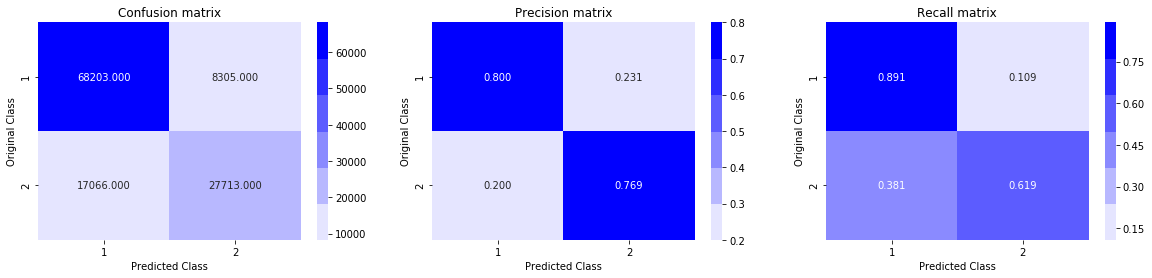

In [129]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [ ]:
def cacheContents(callLogs):
    count_dict = {}
    cache_values = []
    call_log_dict = {}
    min_time = math.inf
    max_time = -math.inf
    for time, value in callLogs:
        if time > max_time:
            max_time = time
        if time < min_time:
            min_time = time
        if call_log_dict.get(time):
            call_log_dict[time].append(value)
        else:
            call_log_dict[time] = [value]
    for time in range(min_time, max_time+1):
    values = call_log_dict[time]
    for c_key, c_value in count_dict.items():
    if c_value > 0 and c_key not in values:
    count_dict[c_key] -= 1
    for value in values:
    if count_dict.get(value):
    count_dict[value] += 2
    else:
    count_dict[value] = 2
    for count_key, value in count_dict.items():
    if value > 5 and count_key not in cache_values:
    cache_values.append(count_key)
    if value <= 3 and count_key in cache_values:
    cache_values.remove(count_key)
    return cache_values